# Sea surface temperature: historical time-series
----

J. Potemra<br>
February 2024

----
This notebook will access satellite-derived sea surface temperature (SST) and produce a line plot of the historical SST's along with the seasonal mean and long-term trend.

The data used are a Global High-resolution SST (GHRSST) product, specifically the Level-4, daily Global SST & Sea Ice Analysis from the UK Met Office (METOFFICE-GLO-SST-L4-REP-OBS-SST-V2)<sup>1</sup>.

The OSTIA global sea surface temperature reprocessed product provides daily gap-free maps of foundation sea surface temperature and ice concentration (referred to as an L4 product) at 0.05<sup>o</sup> x 0.05<sup>o</sup> horizontal grid resolution, using re-processed ATSR data, AVHRR Pathfinderdata and _in-situ_ data from ICOADS. This product provides the foundation Sea Surface Temperature, which is the temperature free of diurnal variability.

In this notebook the data are accessed from the Asia-Pacific Data Research Center (http://apdrc.soest.hawaii.edu) via an OPeNDAP call, and we use the period __1982__ through __2020__ for the seasonal climatology.

-------
<sup>1</sup>C.J. Donlon, M. Martin,J.D. Stark, J. Roberts-Jones, E. Fiedler, W. Wimmer. The operational sea surface temperature and sea ice analysis (OSTIA) system. Remote Sensing Environ., 116 (2012), pp. 140-158 http://dx.doi.org/10.1016/j.rse.2010.10.017 Please abide by their data use policy and acknowledge the use of these data with the following statement: These data were provided by GHRSST, Met Office and CMEMS.

## Import needed packages

In [1]:
# data I/O and processing
import xarray as xr
import pandas as pd
import numpy as np
import pickle

# regression, fitting, etc.
from scipy import linalg
import matplotlib.dates as mdates

# data plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Define functions to read data
The data are available on the APDRC OPeNDAP server at http:/apdrc.soest.hawaii.edu:80/dods/public_data/satellite_product/GHRSST/ghrsst_global_UKMO_OSTIA_REP.  Here we define two functions to read the data.  One __get_remote__ is from the OPeNDAP call.  Note this can take a _very_ long time (hours) if a large request is made.  The data are daily going back to 1981.  The other function, __get_local__ reads the data from a local disk.  This is much quicker, but relies on the data being in yearly "pickle" files.


In [2]:
# get the data from the APDRC OPeNDAP server; need to supply the latitude and longitude ranges
# along with start and end year
def get_remote(min_lon,max_lon,min_lat,max_lat,min_year,max_year):
    min_date = min_year + '-01-01'
    max_date = max_year + '-12-31'
    
    # set URL
    url = 'http:/apdrc.soest.hawaii.edu:80/dods/public_data/satellite_product/GHRSST/ghrsst_global_UKMO_OSTIA_REP'

    # read data
    ds = xr.open_dataset(url)
    
    # slice the data to region and time
    ds = ds.sel( lat = slice(min_lat,max_lat), lon = slice(min_lon,max_lon), time=slice(min_date,max_date))
    return ds

In [3]:
# get data from local disk; note that in this case the data are in annual files, so just
# need specify start and end years
def get_local(lon,lat,min_year,max_year):
    iter = 0
    for year in range (int(min_year),int(max_year)+1):
        infile = './data/GHRSST_' + str(year) + '.pkl'
        fileObject = open(infile,'rb')
        ds1 = pickle.load(fileObject)
        fileObject.close()
        obs_lon = ds1['lon'].to_numpy()
        i = np.argmin(np.abs(obs_lon-lon))
        obs_lat = ds1['lat'].to_numpy()
        j = np.argmin(np.abs(obs_lat-lat))
        ds2 = ds1['sst'][:,j,i]
        ds = ds2 if iter==0 else xr.merge([ds,ds2])
        iter += 1
    return ds

In [4]:
# Function to fit harmonics and compute trend of residuals
def fit_harm(time,var):
    #var.fillna(np.nanmean(var), inplace=True)
    var = np.nan_to_num(var,copy=True,nan=np.nanmean(var))
    nt = len(var)
    t = mdates.date2num(time)

# define basis functions, there will be one for the mean (0), two
#   for the daily cycle (1-2), two for the semi-annual harmonic (3-4), 
#   two for the annual cycle (5-6), and two for the decadal cycle (7-8)

    X = np.ones((nt,9),dtype=float)
    DayFit = np.ones(nt)
    MonFit = np.ones(nt)
    w_day = 2.0 * np.pi / 24.0
    w_san = w_day * 2.0 / 365.25
    w_ann = w_day / 365.25
    w_dec = w_day / 3652.5
    for k in range(nt):
        X[k,0] = 1
        X[k,1] = np.cos(k*w_day)
        X[k,2] = np.sin(k*w_day)
        X[k,3] = np.cos(k*w_san)
        X[k,4] = np.sin(k*w_san)
        X[k,5] = np.cos(k*w_ann)
        X[k,6] = np.sin(k*w_ann)
        X[k,7] = np.cos(k*w_dec)
        X[k,8] = np.sin(k*w_dec)

    alpha = 0.05
    Bfit = linalg.lstsq(X, var)[0] # ignore other outputs
    DayFit = X[:,1] * Bfit[1] + X[:,2] * Bfit[2]
    MonFit = X[:,3] * Bfit[3] + X[:,4] * Bfit[4] + X[:,5] * Bfit[5] + X[:,6] * Bfit[6]
    fitvar = np.dot(X, Bfit)
    yresid = var - fitvar
    B = np.polyfit(t,yresid,1)
    YResidFit = np.polyval(B,t)
# get trend in [units] per decade (from per day)
    trend = B[0] * 365.25 * 10.0
    
    return(YResidFit,trend)

## Select point (lat/lon) for analysis and display

In [5]:
# define lat/lon range for Palau
xlon = 134.0
ylat = 7.0

# define time range
min_year = 1982
max_year = 2020

## Read data
Note the data is not read until "needed."  In this case, not until monthly mean calculation.  This takes a long time, especially with a long time-range, since the data are daily.  Instead there is the option to read the data from local disk (read once, then access faster).  

In [6]:
# do a remote OPeNDAP read
#ds = get_remote(min_lon,max_lon,min_lat,max_lat,min_year,max_year)
# do a local read
sst_daily = get_local(xlon,ylat,min_year,max_year) - 273.15

## Compute the monthly means, then climatological year

In [7]:
# start with daily files, create monthly means; Note data are in Kelvin
sst_monthly = sst_daily['sst'].resample(time='1MS').mean(dim='time') 

# create a monthly mean climatology
sst_mean_annual = sst_monthly.groupby('time.month').mean('time')

# expand climatology to range over the entire time range
#  - create a monthly time series
date_range = xr.cftime_range( str(min_year) + '-01-01', str(max_year) + '-12-31', freq="MS")
#  - access the month index (1, 2, ..., 12) for each date:
months = date_range.month
#  - create a DataArray from the above. The coordinate is the full date range
#    and will become the time dim in the result. The values are the months
#    that we would like to select from the climatology
selector = xr.DataArray(months, dims=["time"], coords=[date_range])
#  - select from the climatology, reshaping to be indexed by `time`
sst_climatology = sst_mean_annual.sel(month=selector)

In [8]:
# calculate the longterm trend
sst_trend_vals, sst_trend = fit_harm(sst_daily['time'].values,sst_daily['sst'].values)

## Make a plot
Here we define a couple functions to add fancy axes and maps/coastlines to our figures.  First we set some "global attributes" like the geographic extent of the maps, map projection, _etc._

/var/folders/00/m_p76xcd75jg4kx7_wyjwd500000gn/T/ipykernel_98515/896916354.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(xlabels)


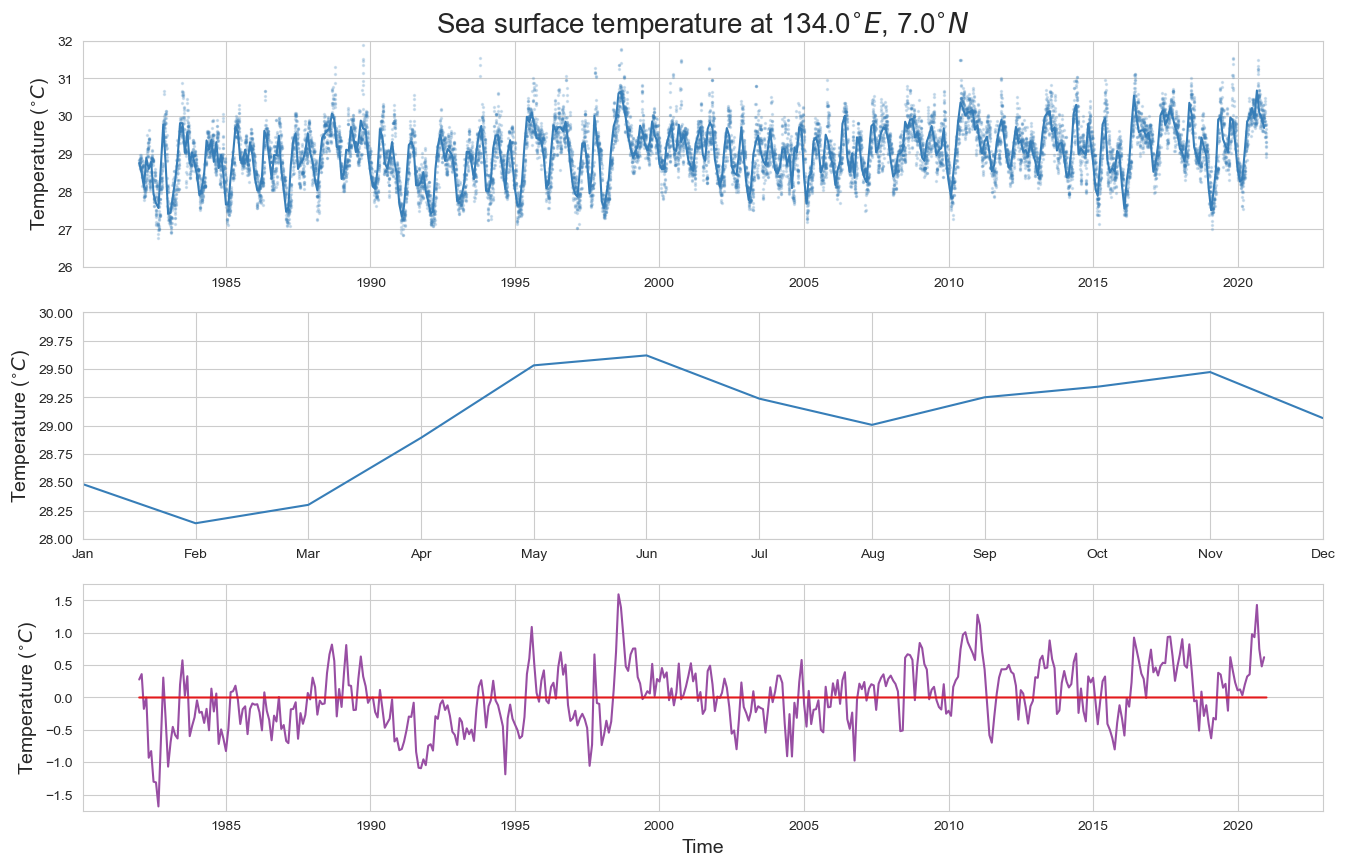

In [9]:
# Set the style of the plot
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("Set1")

# Plot the timeseries
# Create the figure and the axes
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(16,10))

# plot raw, daily and monthly mean values
ax[0].scatter(sst_daily['time'], sst_daily['sst'], label='Daily', color=palette[1], alpha=0.2, s= 2)
ax[0].plot(sst_monthly['time'], sst_monthly, label='Monthly mean', color=palette[1], linestyle='-')
#ax[0].set_xlabel('Time',fontsize=14)
ax[0].set_ylabel('Temperature ($^{\circ}C$)',fontsize=14)
ax[0].set_ylim([26,32])
ax[0].set_title('Sea surface temperature at ' + str(xlon) + '$^{\circ}E$, ' + str(ylat) + '$^{\circ}N$',fontsize=20)

# plot the mean annual cycle
xlabels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax[1].plot(sst_mean_annual['month'],sst_mean_annual, color=palette[1])
ax[1].set_ylabel('Temperature ($^{\circ}C$)',fontsize=14)
ax[1].set_xlim([1,12])
ax[1].locator_params(axis='x', nbins=12) 
ax[1].set_xticklabels(xlabels)
ax[1].set_ylim([28,30])

# plot the monthly anomalies
ax[2].plot(sst_monthly['time'], sst_monthly - sst_climatology, label='Climatology', color=palette[3])
ax[2].plot(sst_daily['time'],sst_trend_vals,color=palette[0])
ax[2].set_xlabel('Time',fontsize=14)
ax[2].set_ylabel('Temperature ($^{\circ}C$)',fontsize=14)
ax[2].set_ylim([-1.75,1.75])

plt.savefig('./images/temp_hist_ts.png')